In [1]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    import os

    drive.mount('/content/drive')
    os.chdir('/content/drive/Shareddrives/Confidence Probes/taskdiscovery')
    !pip3 install transformer_lens fancy_einsum einops datasets encoders plotly

else:
    print("Not running in Google Colab, skipping installation of requirements.")

Not running in Google Colab, skipping installation of requirements.


In [2]:
# del sys.modules["hooks"]

In [3]:
from transformer_lens import HookedTransformer
from datasets import load_dataset
from data import load_ICL_dataset,word_pairs_to_prompt_data,create_prompt,FVDataset,retrieve_owt_data
from training_utils import fit_beta_model
from hooks import save_, attn_filter, pattern_filter, pre_filter
from torch.utils.data import DataLoader
from fancy_einsum import einsum
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from torch.nn import functional as F
from functools import partial
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import torch
import math
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
from collections import Counter
import random
import os
import pickle

In [4]:
batch_size = 8
ctx_length = 128
model_name = "gpt2-small"
device = torch.device("cuda")
model = HookedTransformer.from_pretrained(model_name, device=device)
tokenizer = model.tokenizer
owt_loader = retrieve_owt_data(batch_size, ctx_length, tokenizer)

model.cfg.use_attn_result = True
n_layers = 12

Loaded pretrained model gpt2-small into HookedTransformer


Map (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (61422 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (58948 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (59558 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (71857 > 1024). Running this sequence through the model will result in indexing errors


## OWT Attention Mean Calculator
Should probably just reload the pre-saved weights most of the times. Takes about an hour to run 10000 iterations with batch size of 8.

In [5]:
attention_results = 0
mean_samples = 0
for i in tqdm(range(10000)):
  with torch.no_grad():
    input_ids  = next(iter(owt_loader))["tokens"]
    attention_mask = torch.ones_like(input_ids)
    attention_mask = torch.where(input_ids == tokenizer.eos_token_id, 0 , attention_mask)
    attention_mask[:,0] = 1
    mean_samples += attention_mask[:,1:].sum()

    attn_storage = []
    output = model.run_with_hooks(
                      input_ids,
                      attention_mask = attention_mask,
                      fwd_hooks=[(attn_filter,partial(save_, attn_storage),) ]

              )

    # attn_mask: [bsz, seq_pos]
    # attn_storage: [n_layers, bsz, seq_pos, n_heads, d_model]
    # attention_results : [n_layers, n_heads, d_model]
    attention_results += (torch.stack(attn_storage, dim=0) * attention_mask.unsqueeze(-1).unsqueeze(-1).to(device))[:,:,1:].sum(dim=[1,2]).cpu()

attention_results = attention_results / mean_samples

output_file = "output/owt_mean_attentions.pkl"
with open(output_file, "wb") as f:
    pickle.dump(attention_results, f)

  5%|▍         | 494/10000 [02:25<46:45,  3.39it/s]


KeyboardInterrupt: 

In [6]:
output_file =  "output/owt_mean_attentions.pkl"
with open(output_file, "rb") as f:
    mean_attn = pickle.load(f)

## Process ICL Task Dataset
Should probably load the entire dataset and not preprocess every time we run the notebook.

In [7]:
d = {"prompt":[], "label": [], "task" : []}

for task in os.listdir("function_vectors_data/abstractive") + os.listdir("function_vectors_data/extractive"):
    task = task.replace(".json", "")
    dataset = load_ICL_dataset(task)

    print("Task: ", task, "train len:", len(dataset['train']), "test len:",len(dataset['test']) )

    for test_pair in dataset['test']:
        for i in range(10):
            choices = random.choices(dataset['train'],k=5)
            word_pairs = {"input": [x["input"] for x in choices],
                        "output": [x["output"] for x in choices]}
            prompt_data = word_pairs_to_prompt_data(word_pairs, query_target_pair=test_pair, prepend_bos_token=True)
            sentence = create_prompt(prompt_data)
            d["prompt"].append(sentence)
            d["label"].append(test_pair["output"])
            d["task"].append(task)

    for test_pair in dataset['train']:
      for i in range(10):
          choices = random.choices(dataset['test'],k=5)
          word_pairs = {"input": [x["input"] for x in choices],
                      "output": [x["output"] for x in choices]}
          prompt_data = word_pairs_to_prompt_data(word_pairs, query_target_pair=test_pair, prepend_bos_token=True)
          sentence = create_prompt(prompt_data)
          d["prompt"].append(sentence)
          d["label"].append(test_pair["output"])
          d["task"].append(task)

df = pd.DataFrame(d)

Task:  capitalize train len: 569 test len: 170
Task:  landmark-country train len: 585 test len: 175
Task:  person-instrument train len: 357 test len: 107
Task:  national_parks train len: 315 test len: 95
Task:  word_length train len: 569 test len: 171
Task:  synonym train len: 2016 test len: 604
Task:  ag_news train len: 5320 test len: 1596
Task:  present-past train len: 205 test len: 61
Task:  next_item train len: 157 test len: 47
Task:  sentiment train len: 816 test len: 245
Task:  english-spanish train len: 3639 test len: 1092
Task:  english-french train len: 3288 test len: 987
Task:  person-sport train len: 222 test len: 67
Task:  product-company train len: 365 test len: 109
Task:  english-german train len: 3601 test len: 1080
Task:  antonym train len: 1678 test len: 504
Task:  park-country train len: 524 test len: 157
Task:  country-currency train len: 137 test len: 42
Task:  commonsense_qa train len: 7673 test len: 2302
Task:  country-capital train len: 137 test len: 42
Task:  pr

In [8]:
df = pd.read_csv("function_vectors_data/ICL_dataset.csv")
df

FileNotFoundError: [Errno 2] No such file or directory: 'function_vectors_data/ICL_dataset.csv'

## Prepare Torch Dataset

In [ ]:
included_tasks = ["present-past", "capitalize",  "singular-plural", "word_length", "english-spanish"]
included_tasks += ['adjective_v_verb_3', 'alphabetically_first_3','choose_first_of_3', 'object_v_concept_3']
min_len = 10000

for task in included_tasks:
    task_set = df[df["task"] == task]
    if len(task_set) < min_len:
        min_len = len(task_set)

print("data points per task", min_len)

task_dfs = []
for task in included_tasks:
    task_set = df[df["task"] == task].copy().reset_index()
    task_dfs.append(task_set.iloc[np.random.choice(len(task_set), min_len)])

df_subset = pd.concat(task_dfs)
df_subset = df_subset.dropna()

data points per task 1860


In [ ]:
tokenized_data = []
tasks = []
labels = []

for idx,row in df_subset.iterrows():
    x = tokenizer(row["prompt"], max_length=128, truncation=True, padding='max_length', return_tensors="pt")
    if x['attention_mask'][-1,-1] == 1:
        continue
    tokenized_data.append(x)
    tasks.append(row["task"])
    labels.append(row["label"])

print(len(tokenized_data))

16734


In [ ]:
dataset = FVDataset(tokenized_data,tasks, labels)
batch_size = 1
dl = DataLoader(dataset, batch_size=batch_size, shuffle=False,drop_last=True)

In [ ]:
tokenizer.batch_decode(next(iter(dl))[0])

/content/drive/Shareddrives/Confidence Probes/taskdiscovery/data.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, dtype=torch.long)
/content/drive/Shareddrives/Confidence Probes/taskdiscovery/data.py:559: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask, dtype=torch.long)


['<|endoftext|>Q: extend\nA: extended\n\nQ: define\nA: defined\n\nQ: receive\nA: received\n\nQ: travel\nA: traveled\n\nQ: make\nA: made\n\nQ: calculate\nA:<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

## Save Hidden State and Attention Entropy on ICL Tasks

In [ ]:
attention_results = 0
all_activations = []
tasks = []
entropies = []
corrects= 0

mean_samples = 0

last_task = "place_holder"
num_corr = 0
task_counter = 0

valid_inputs = []

for batch in tqdm(dl):
  with torch.no_grad():
    attn_storage = []
    act_storage = []
    pattern_storage = []

    labels = batch[-1]

    # attn_mask: [bsz, seq_pos]
    attn_mask =  batch[1]
    # output:  [batch, tokens, vocab size]
    output = model.run_with_hooks(
                    batch[0],
                    attention_mask = batch[1],
                    fwd_hooks=
                    [(pre_filter,partial(save_, act_storage),) ] +
                    [(pattern_filter,partial(save_, pattern_storage),) ]

            )
    # last_token_idx: [bsz]
    last_token_idx = attn_mask.cumsum(1).argmax(1)
    #activations:  [layer, bsz, d_model]
    activations = torch.stack(act_storage)[:, torch.arange(batch_size), last_token_idx, :]


    predicted_labels = tokenizer.batch_decode(output[torch.arange(batch_size), last_token_idx,:].argmax(-1))

    # pattern_storage: [n_layers, bsz, n_heads, seq_pos, seq_pos]
    patterns = torch.stack(pattern_storage).permute(0,2,1,3,4)[:,:,torch.arange(batch_size), last_token_idx, :].permute(2,0,1,3)

    # entropy: [bsz, n_layers * n_heads]
    entropy = (- patterns * (patterns + 1e-10).log()).sum(-1).flatten(1,2)


    for i, predicted_label, label in zip(list(range(len(labels))) ,predicted_labels, labels):
      task = batch[2][i]

      if task != last_task:
        print("\n\nTask Finished: ", last_task )
        print("Total: ", task_counter)
        print("Num Correct: ", num_corr )
        print()
        num_corr =0
        task_counter = 0
        last_task = task


      if label.strip().startswith(predicted_label.strip()):
        entropies.append(entropy.cpu()[i:i+1])
        all_activations.append(activations.cpu()[:, i:i+1, :])
        tasks += [batch[2][i]]
        num_corr += 1
        #TODO: This does not work with batchsize != 1
        valid_inputs.append([batch[0].to("cpu"), batch[1].to("cpu"), batch[2], batch[3]])

      task_counter += 1


  0%|          | 0/16734 [00:00<?, ?it/s]/content/drive/Shareddrives/Confidence Probes/taskdiscovery/data.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, dtype=torch.long)
/content/drive/Shareddrives/Confidence Probes/taskdiscovery/data.py:559: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask, dtype=torch.long)
  0%|          | 2/16734 [00:00<20:44, 13.44it/s]



Task Finished:  place_holder
Total:  0
Num Correct:  0



 11%|█         | 1857/16734 [01:31<11:27, 21.63it/s]



Task Finished:  present-past
Total:  1854
Num Correct:  1731



 22%|██▏       | 3719/16734 [03:04<09:58, 21.75it/s]



Task Finished:  capitalize
Total:  1860
Num Correct:  1467



 33%|███▎      | 5578/16734 [04:38<09:21, 19.87it/s]



Task Finished:  singular-plural
Total:  1860
Num Correct:  1798



 44%|████▍     | 7437/16734 [06:16<07:25, 20.86it/s]



Task Finished:  word_length
Total:  1860
Num Correct:  255



 56%|█████▌    | 9298/16734 [07:47<05:42, 21.74it/s]



Task Finished:  english-spanish
Total:  1860
Num Correct:  217



 67%|██████▋   | 11158/16734 [09:19<05:37, 16.52it/s]



Task Finished:  adjective_v_verb_3
Total:  1860
Num Correct:  1031



 78%|███████▊  | 13019/16734 [10:51<02:51, 21.67it/s]



Task Finished:  alphabetically_first_3
Total:  1860
Num Correct:  593



 89%|████████▉ | 14877/16734 [12:23<01:37, 18.98it/s]



Task Finished:  choose_first_of_3
Total:  1860
Num Correct:  1577



100%|██████████| 16734/16734 [13:52<00:00, 20.09it/s]


In [ ]:
all_activations = torch.cat(all_activations, 1)
entropies = torch.cat(entropies,0)

print("mean attn shape:" , mean_attn.shape)
print("all activations shape:", all_activations.shape)
print("entropies shape:", entropies.shape)

mean attn shape: torch.Size([12, 12, 768])
all activations shape: torch.Size([12, 9996, 768])
entropies shape: torch.Size([9996, 144])


In [ ]:
def calculate_f1_cost_matrix(true_labels, predicted_clusters, n_labels, n_clusters):
    cost_matrix = np.zeros((n_labels, n_clusters))

    for i in range(n_labels):
        for j in range(n_clusters):

            temp_true_labels = np.array(true_labels == i, dtype=int)
            temp_predicted_labels = np.array(predicted_clusters == j, dtype=int)
            f1 = accuracy_score(temp_true_labels, temp_predicted_labels)
            cost_matrix[i, j] = 1 - f1

    return cost_matrix

def fit_cluster(x,y):
  label_encoder = LabelEncoder()
  true_labels = label_encoder.fit_transform(y)

  train_x, test_x, train_y, test_y = train_test_split(x, true_labels,test_size=0.1, random_state = 43)

  kmeans = KMeans(n_clusters=len(Counter(true_labels)),n_init =10, random_state=0).fit(train_x)

  predicted_labels = kmeans.labels_

  M = calculate_f1_cost_matrix(train_y, predicted_labels,len(Counter(true_labels)),len(Counter(true_labels)) )
  row, col = linear_sum_assignment(M)
  map = {}
  for i in range(len(row)):
    map[row[i]] = col[i]

  vectorized_map = np.vectorize(lambda x: map.get(x, x))
  train_y = vectorized_map(train_y)
  test_y = vectorized_map(test_y)

  # Calculate "accuracy"
  accuracy = accuracy_score(train_y, predicted_labels)
  print(f"train accuracy: {accuracy}")

  test_predict = kmeans.predict(test_x)

  # Calculate "accuracy"
  test_accuracy = accuracy_score(test_y, test_predict)
  print(f"test accuracy: {test_accuracy}")

  # # Calculate per category F1 score
  f1_scores = f1_score(test_y, test_predict, average=None)
  category_f1_scores = dict(zip(label_encoder.classes_, f1_scores))
  print("Task f1 scores: ")
  for key,value in category_f1_scores.items():
     print(key, value)


  return kmeans.predict(x)



## Cluster first N PCA components on entropies

In [ ]:
pca = PCA()
pca_projections = pca.fit_transform(entropies)
cluster_predictions = fit_cluster(pca_projections[:, :20],tasks )

train accuracy: 0.6522899066251667
test accuracy: 0.627
Task f1 scores: 
adjective_v_verb_3 0.7821522309711286
alphabetically_first_3 0.726643598615917
capitalize 0.6696035242290748
choose_first_of_3 0.0
english-spanish 1.0
object_v_concept_3 0.7035830618892508
present-past 0.616600790513834
singular-plural 0.4840764331210191
word_length 1.0


In [ ]:
mask = np.array([0 if (task == "object_v_concept_3") else 1 for task in tasks])
pca_projections = pca.fit_transform(entropies)[mask.astype(bool)]
cluster_predictions = fit_cluster(pca_projections[:, :20],np.array(tasks)[mask.astype(bool)] )

train accuracy: 0.7881312483978467
test accuracy: 0.7635524798154556
Task f1 scores: 
adjective_v_verb_3 0.972972972972973
alphabetically_first_3 0.7747252747252749
capitalize 0.683453237410072
choose_first_of_3 0.9702380952380952
english-spanish 0.8602150537634409
present-past 0.4
singular-plural 0.9545454545454545
word_length 0.6990291262135923


<Axes: >

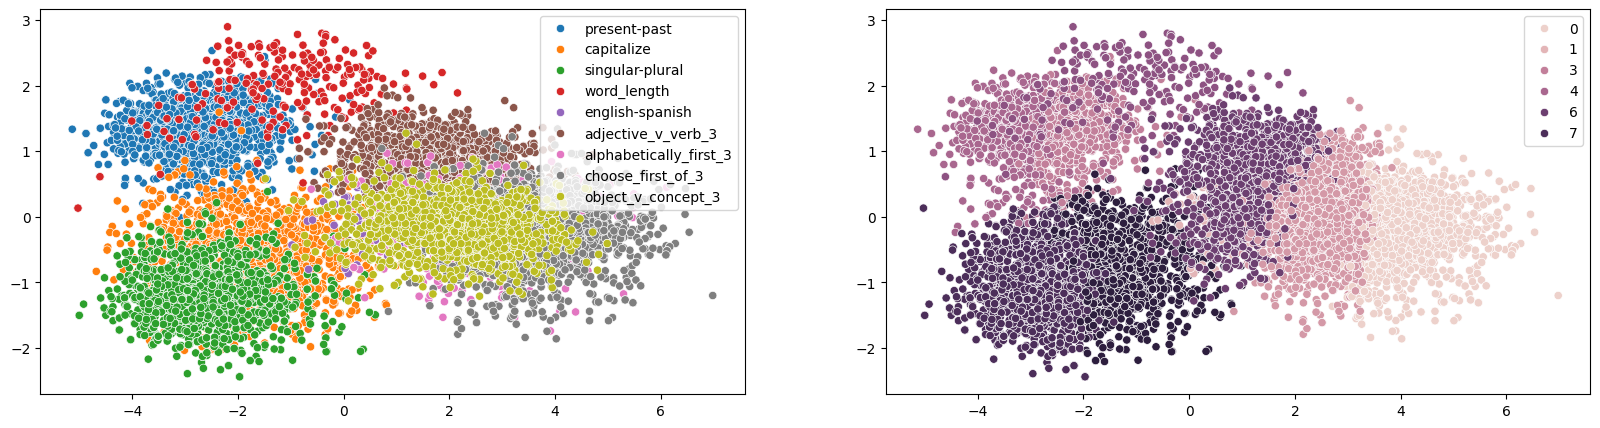

In [ ]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(tasks)
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.scatterplot(x= pca_projections[:,0], y =pca_projections[:,1],hue=tasks)
plt.subplot(1,2,2)
sns.scatterplot(x= pca_projections[:,0], y =pca_projections[:,1],hue=cluster_predictions)

In [ ]:
def fit_linreg(x, y):
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(y)

    train_x, test_x,train_y, test_y, = train_test_split(x, true_labels)

    lm = LogisticRegression(random_state=0).fit(train_x, train_y)

    predicted_labels = lm.predict(train_x)

    # Calculate "accuracy"
    accuracy = accuracy_score(train_y, predicted_labels)
    print(f"train accuracy: {accuracy}")

    test_predict = lm.predict(test_x)

    # Calculate "accuracy"
    test_accuracy = accuracy_score(test_y, test_predict)
    print(f"test accuracy: {test_accuracy}")

    return accuracy, test_accuracy

In [ ]:
_,_ = fit_linreg(entropies, tasks)

train accuracy: 0.9649703331811958
test accuracy: 0.9599589322381931


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
plt.figure(figsize=(24, 24))  # Adjusted figure size to provide more room

x = all_activations[8]
pca = PCA()
pca_projections = pca.fit_transform(x)


# Loop to create subplots
for i in range(1, 16):  # Adjusted to 10 subplots for PCA 1 vs PCA 2 to PCA 11
    ax = plt.subplot(5, 3, i)  # Adjust grid size to accommodate legends outside
    sns.scatterplot(x=pca_projections[:, 0], y=pca_projections[:, i], hue=tasks, ax=ax)
    plt.title(f'PCA 1 vs PCA {i+1}')
    plt.xlabel('PCA 1')
    plt.ylabel(f'PCA {i+1}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for layer in range(n_layers):
  x = all_activations[layer]
  print(f"Layer {layer}")
  fit_cluster(x, tasks)
  print(f"Layer {layer} pca")
  pca = PCA()
  pca_projections = pca.fit_transform(x)
  fit_cluster(pca_projections[:,:5], tasks)

Layer 0
train accuracy: 0.4524189867640347
test accuracy: 0.4407939767282683
Layer 0 pca
train accuracy: 0.43210862619808305
test accuracy: 0.42984257357973993
Layer 1
train accuracy: 0.5569374714742127
test accuracy: 0.555441478439425
Layer 1 pca
train accuracy: 0.5476951163852122
test accuracy: 0.5557837097878165
Layer 2
train accuracy: 0.5418758557736193
test accuracy: 0.5420944558521561
Layer 2 pca
train accuracy: 0.5806709265175719
test accuracy: 0.5715263518138262
Layer 3
train accuracy: 0.5929940666362392
test accuracy: 0.6105407255304586
Layer 3 pca
train accuracy: 0.4601780009128252
test accuracy: 0.4514031485284052
Layer 4
train accuracy: 0.5637836604290278
test accuracy: 0.5390143737166324
Layer 4 pca
train accuracy: 0.5705157462345961
test accuracy: 0.5609171800136893
Layer 5
train accuracy: 0.5460976722957553
test accuracy: 0.5314852840520191
Layer 5 pca
train accuracy: 0.48208580556823366
test accuracy: 0.4869952087611225
Layer 6
train accuracy: 0.7434961204929256
test ac

In [ ]:
attention_scores = []

# n_heads * batch_size x tokens x n_heads x dim
# [i ,:,i,:] will be 1s
seq_len = 128
mask = torch.eye(12,device = device).unsqueeze(1).unsqueeze(-1).bool()
mask = mask.expand(-1, seq_len - 1, -1, 768).repeat_interleave(batch_size,dim=0)

def attn_mean_ablation(mean, result, hook):
  n_heads = model.cfg.n_heads
  result[-n_heads * batch_size:,1:] = torch.where(mask, mean.unsqueeze(0).unsqueeze(0).repeat(n_layers*batch_size,seq_len-1,1,1).to(device), result[-n_layers* batch_size:,1:])
  return result

def increase_batch(act,hook):
  return torch.cat([act,act[:batch_size].repeat(n_layers,1,1)],0)

def attn_filter_layer(i,name):
  return name.endswith(f"{i}.attn.hook_result")

def pre_filter(name):
  return name.endswith("resid_pre")


idx = 0
d
kls = []
tasks = []

for batch in tqdm(valid_inputs):
  with torch.no_grad():

    output = model.run_with_hooks(
                    batch[0],
                    attention_mask = batch[1],
                    fwd_hooks=[(partial(attn_filter_layer,i),partial(attn_mean_ablation, mean_attn[i]),)  for i in range(n_layers)] +
                    [(pre_filter,increase_batch)]
            )

    attn_mask = batch[1]
    last_token_idx = attn_mask.cumsum(1).argmax(1)
    output = output.unflatten(0,(-1,batch_size))
    output = output[:,torch.arange(batch_size), last_token_idx,:]

    kl_loss = F.kl_div(output[1:].softmax(-1).log(), output[0:1].softmax(-1), reduction = 'none').sum(-1).T

    kls.append(kl_loss.cpu().numpy())
    tasks+= list(batch[2])
    # print(tokenizer.decode(batch[0].squeeze()) ,tokenizer.decode(output.argmax(-1)[0]))

    idx += 1


 11%|█         | 1253/11686 [27:49<3:51:43,  1.33s/it]


KeyboardInterrupt: 

In [ ]:
importances = np.concatenate(kls,0)

In [ ]:
_ = fit_cluster(importances,tasks)
pca = PCA().fit(importances)

_ = fit_cluster(pca.transform(importances)[:,:4], tasks)

Train accuracy: 0.16729256482816462
Test accuracy: 0.15549677124199207
Train accuracy: 0.1701803769111547
Test accuracy: 0.16751399738060543


In [ ]:
fit_linreg(np.log(importances), tasks)

train accuracy: 0.7902986857825568
test accuracy: 0.7706093189964157


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.7902986857825568, 0.7706093189964157)

<Axes: ylabel='Count'>

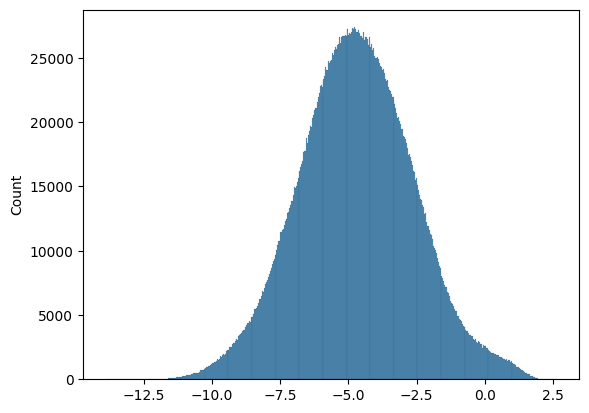

In [ ]:
sns.histplot(np.log(importances.flatten()))

In [ ]:

true_labels = label_encoder.fit_transform(tasks)
pca_results = fit_cluster(np.log(importances) , tasks)

train accuracy: 0.40415770609318996
test accuracy: 0.39842293906810033


In [ ]:
pca = PCA().fit(importances)
pca_reduced_impt = pca.transform(importances)
pca_results = fit_cluster(pca_reduced_impt[:,:20], tasks)

train accuracy: 0.21003584229390682
test accuracy: 0.20802867383512544


In [ ]:
pca = PCA().fit(np.log(importances))

pca_reduced_impt = pca.transform(np.log(importances))
pca_results = fit_cluster(pca_reduced_impt[:,:20], tasks)

train accuracy: 0.4117562724014337
test accuracy: 0.40372759856630824


In [ ]:
importances_normalized = (np.log(importances) - np.log(importances).mean(-1)[...,np.newaxis])   /  np.log(importances).std(-1)[...,np.newaxis]
pca = PCA().fit(importances_normalized)
pca_reduced_impt = pca.transform(importances_normalized)
pca_results = fit_cluster(pca_reduced_impt[:,:20], tasks)

train accuracy: 0.5523058542413382
test accuracy: 0.5446594982078853


In [ ]:
pca_results = fit_cluster(importances_normalized , tasks)

train accuracy: 0.413142174432497
test accuracy: 0.41118279569892474


Text(0, 0.5, 'PC 2')

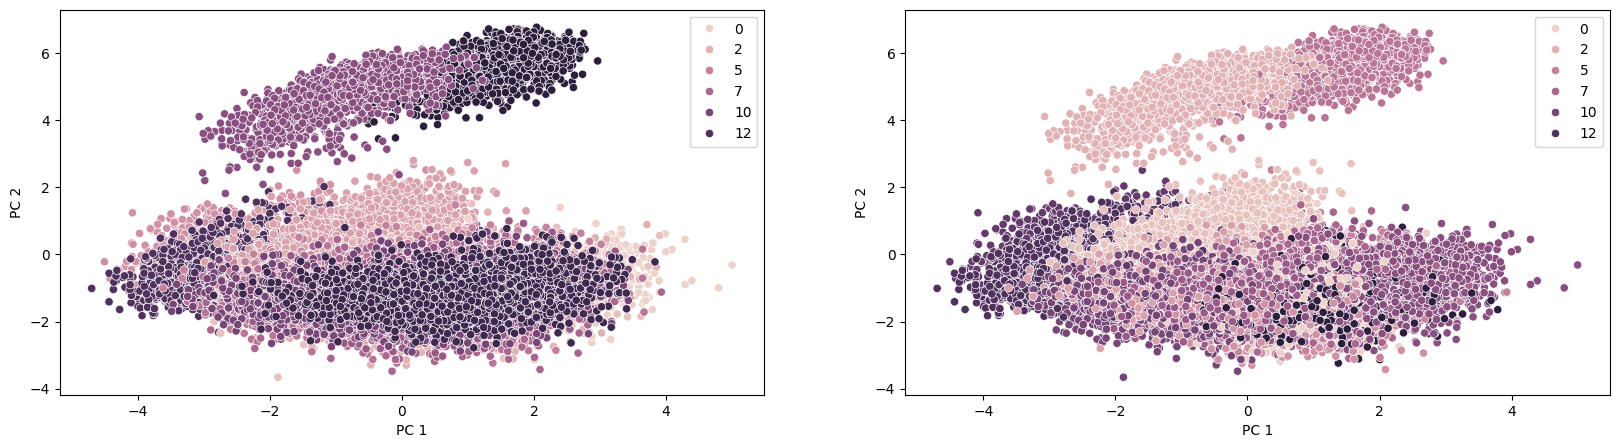

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.scatterplot(x=pca_reduced_impt[:,1], y =pca_reduced_impt[:,0],hue=true_labels)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.subplot(1,2,2)
sns.scatterplot(x=pca_reduced_impt[:,1], y =pca_reduced_impt[:,0],hue=pca_results)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [ ]:
corrs = []
for i in range(144):
  corrs.append(spearmanr(importances[:,i], entropies[:,i].numpy())[0])

plt.figure(figsize=(10, 6))
plt.bar(list(range(len(corrs))), corrs)
plt.xlabel('Columns')
plt.ylabel('Correlation with First Column')
plt.title('Correlation of First Column with All Columns')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 10729 and the array at index 1 has size 83302

In [ ]:
corrs = 0
for i in range(144):
  corrs += pd.DataFrame([entropies[:, i].numpy(), importances[:,i]]).T.corr("spearman").values[1][0]

print(corrs/144)

0.08094276456473279


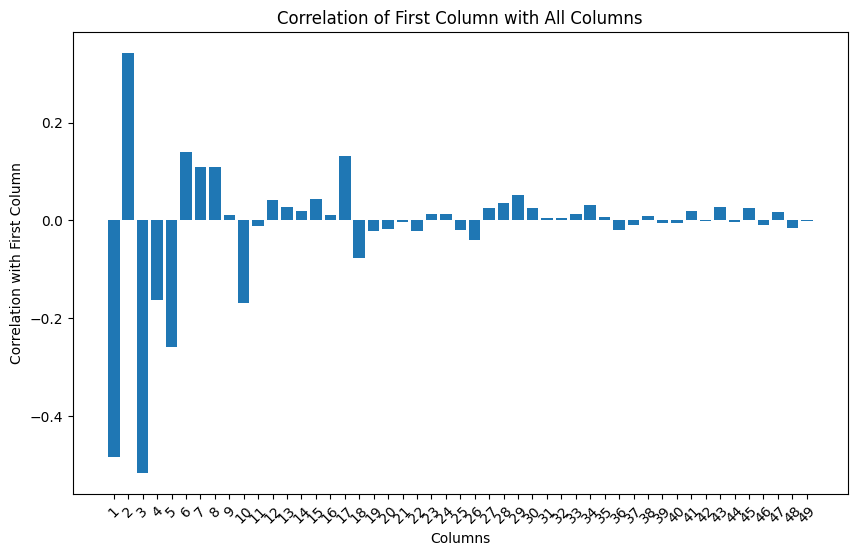

In [ ]:
first_col_corr = pd.DataFrame(np.concatenate([entropies.mean(-1).numpy()[...,np.newaxis], pca_reduced_impt], axis = 1)).corr("spearman").iloc[1:50, 0]


plt.figure(figsize=(10, 6))
plt.bar(first_col_corr.index.astype(str), first_col_corr.values)
plt.xlabel('Columns')
plt.ylabel('Correlation with First Column')
plt.title('Correlation of First Column with All Columns')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.show()

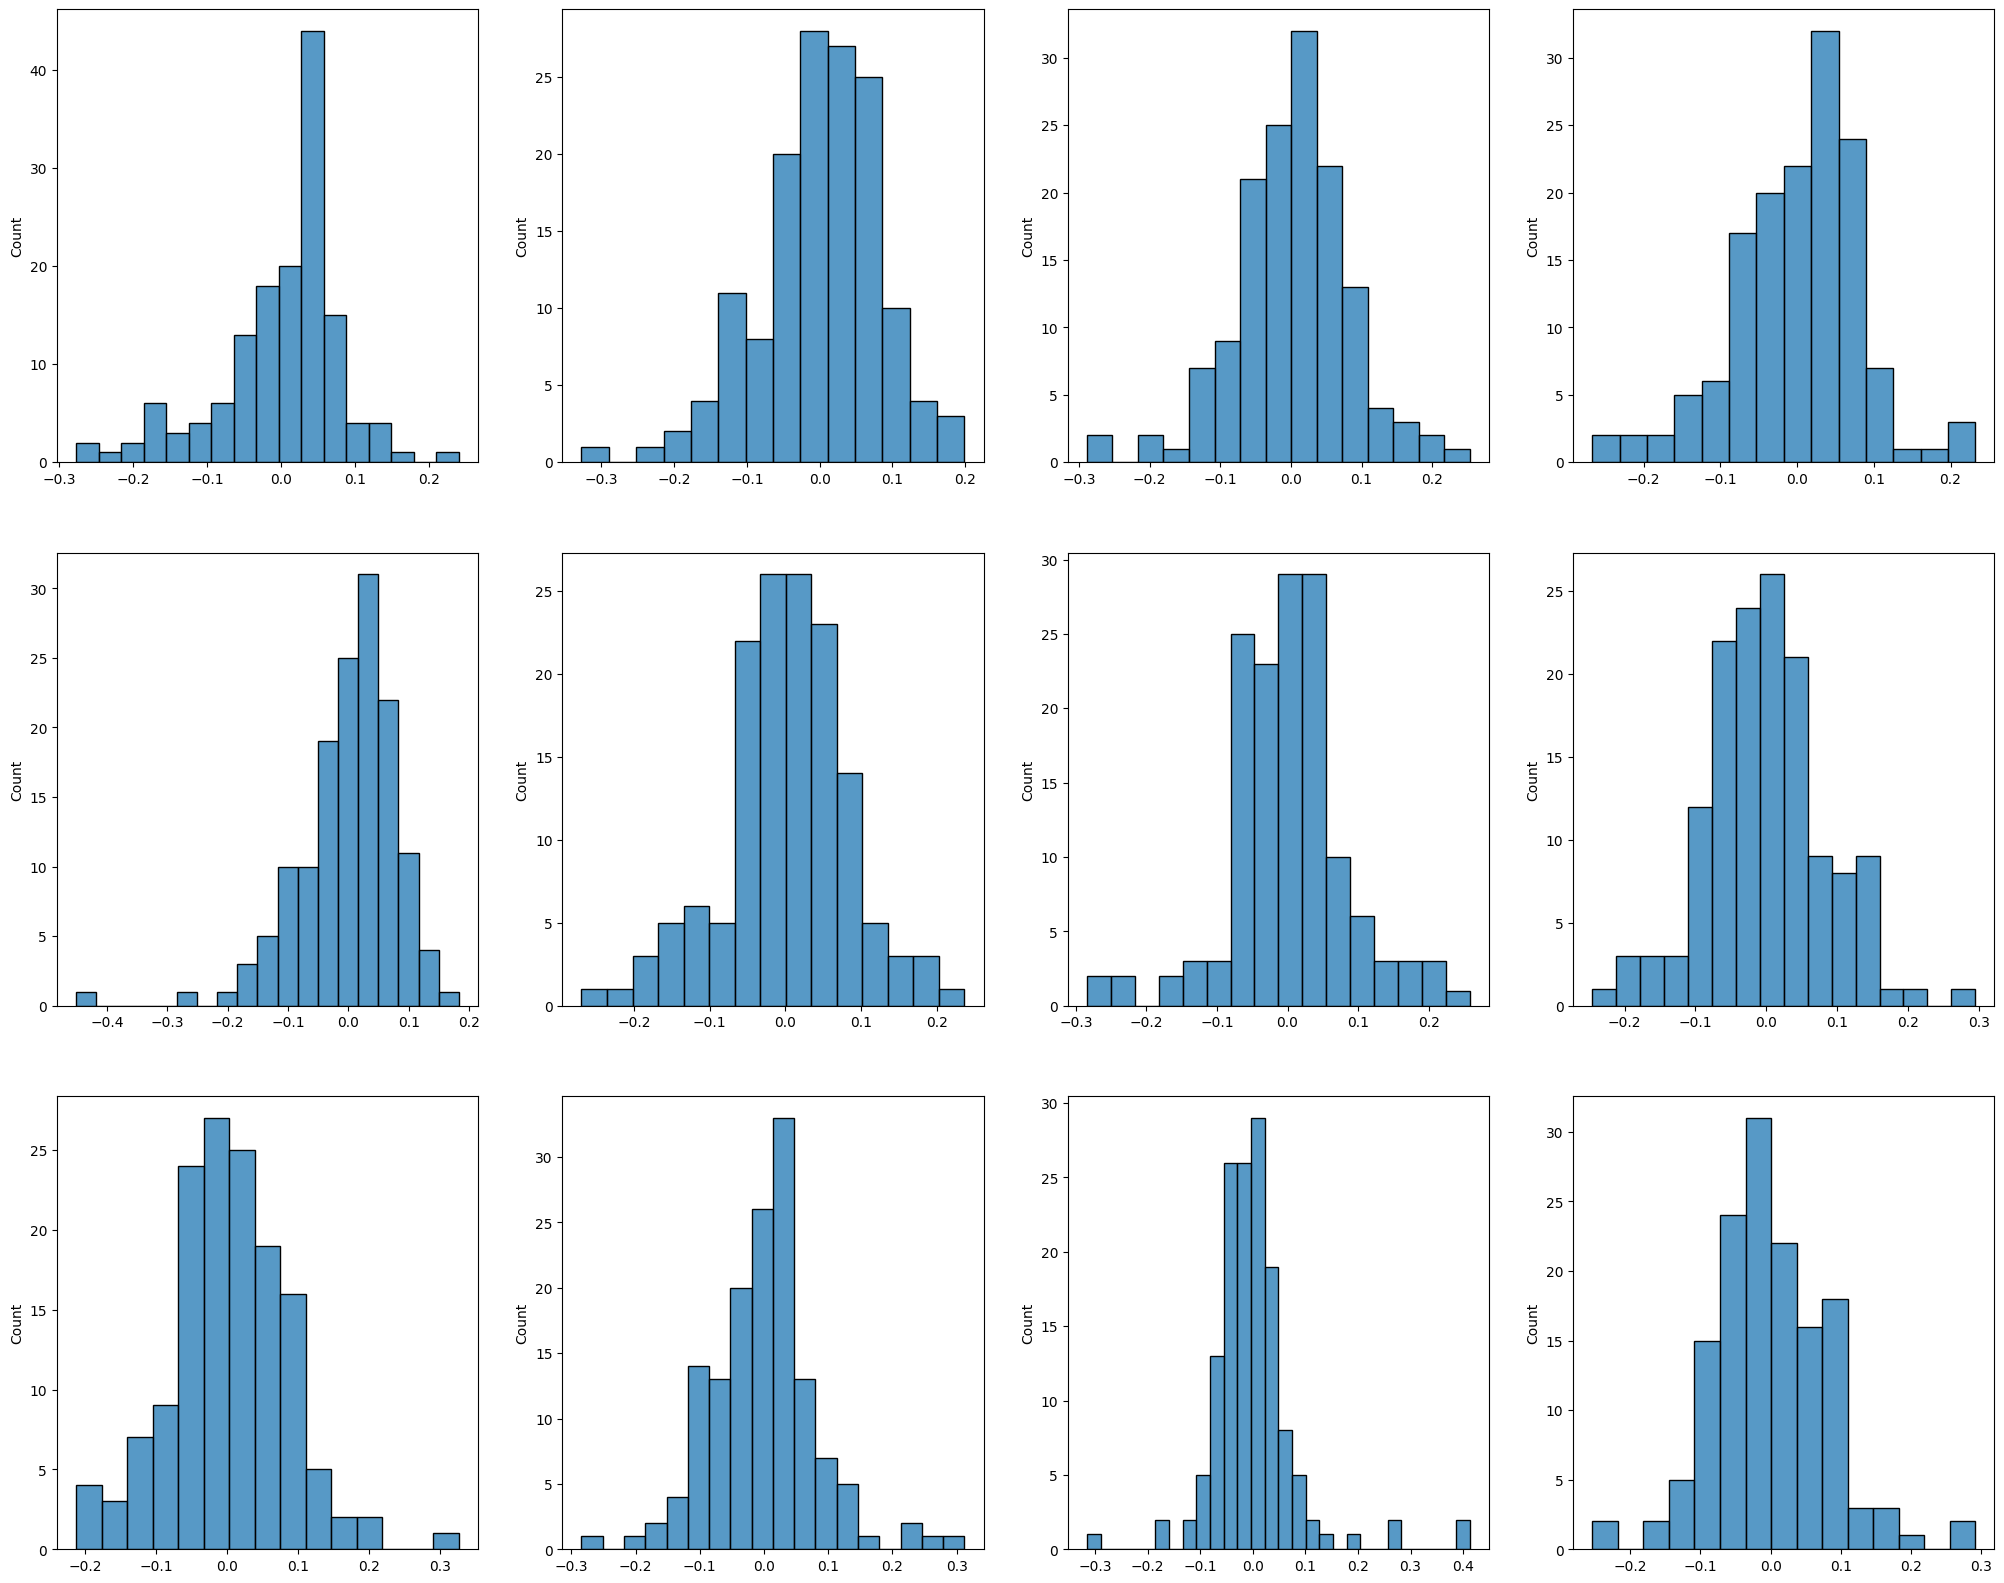

In [ ]:
plt.figure(figsize = (25, 20))
for i,component in enumerate(pca.components_[:12]):
  plt.subplot(3,4, i+1)
  sns.histplot(component)


In [ ]:
fit_linreg(np.log(importances), tasks)
fit_linreg(pca_reduced_impt,  tasks)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


train accuracy: 0.7926881720430108
test accuracy: 0.770179211469534
train accuracy: 0.801194743130227
test accuracy: 0.7822222222222223


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.801194743130227, 0.7822222222222223)

In [ ]:
prompts = []
for batch in tqdm(dl):
  prompts.append(" ".join(tokenizer.batch_decode(batch[0].squeeze())).replace("<|endoftext|> ", ""))


  0%|          | 0/5484 [00:00<?, ?it/s]/content/drive/Shareddrives/Confidence Probes/taskdiscovery/data.py:558: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/content/drive/Shareddrives/Confidence Probes/taskdiscovery/data.py:559: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

100%|██████████| 5484/5484 [00:05<00:00, 1082.03it/s]


In [ ]:
results_df = pd.DataFrame({"pc 0" : pca_reduced_impt[:,0], "prompt": prompts})
results_df["category"] = (results_df["pc 0"] > results_df["pc 0"].mean()).astype(int)
results_df["task"] = true_labels
results_df = results_df.sort_values("pc 0").drop_duplicates().reset_index(drop=True)

results_df["score"] = results_df.apply(lambda x : common_words_score(x), axis = 1)

pd.concat([results_df[results_df["task"] == 2].head(10), results_df[results_df["task"] == 2].tail(10)])

,pc 0,prompt,category,task,score
0,-106.781403,Q : blender \n A : bl enders \n \n Q : tong...,0,2,8547
1,-103.915176,Q : shirt \n A : shirts \n \n Q : oven \n A...,0,2,6137
2,-100.276024,Q : bat \n A : bats \n \n Q : clock \n A : ...,0,2,8842
3,-99.892265,Q : motorcycle \n A : motorcycles \n \n Q : ...,0,2,7989
4,-99.548355,Q : perfume \n A : perf umes \n \n Q : col ...,0,2,6149
5,-97.019211,Q : gr ater \n A : gr aters \n \n Q : axe \...,0,2,8318
6,-96.603081,Q : vacuum \n A : vac u ums \n \n Q : islan...,0,2,6123
7,-95.881119,Q : fabric \n A : fabrics \n \n Q : newspap...,0,2,7912
8,-95.613434,Q : computer \n A : computers \n \n Q : too...,0,2,8643
9,-94.976646,Q : computer \n A : computers \n \n Q : mou...,0,2,7217


In [ ]:
results_df.corr()

<ipython-input-206-419e2a40607f>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,pc 0,category,task,score
pc 0,1.000000,0.782241,-0.510415,-0.375975
category,0.782241,1.000000,-0.419008,-0.318148
task,-0.510415,-0.419008,1.000000,0.671520
score,-0.375975,-0.318148,0.671520,1.000000


In [ ]:
d = {}
for prompt in prompts:

  for word in prompt.split(" "):
    if word in ["Q", ":", "A", "", "\n"] or len(word) < 3:
      continue
    else:
      if word in d:
        d[word] += 1
      else:
        d[word] = 1

def common_words_score(row):
  prompt = row["prompt"]
  score = 0
  for word in prompt.split(" "):
    if word in ["Q", ":", "A", "", "\n"]  or len(word) < 3:
      continue
    else:
      score += d[word]
  return score



In [ ]:
label_encoder.fit_transform( results_df["score"].to_numpy()).max()

165

In [ ]:
results_df["score"].to_numpy()

array([ 28, 440,  28, ...,   1, 167,   9])

In [ ]:
labels = label_encoder.fit_transform( results_df["score"].to_numpy())
lm = LogisticRegression(random_state=0).fit(np.expand_dims(results_df["pc 0"].to_numpy(),1), labels)

predicted_labels = lm.predict(np.expand_dims(results_df["pc 0"].to_numpy(),1))

# Calculate "accuracy"
accuracy = accuracy_score( labels, predicted_labels)
print(f"train accuracy: {accuracy}")

train accuracy: 0.04892891918208374


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



AttributeError: 'numpy.ndarray' object has no attribute 'expand_dims'

In [ ]:
dict(sorted(d.items(), key=lambda item: item[1],reverse=True))

{'tooth': 646,
 'ers': 541,
 'brush': 491,
 'st': 469,
 's': 440,
 'trash': 374,
 'lad': 364,
 'h': 362,
 'ushes': 343,
 'paint': 340,
 'ry': 333,
 'a': 328,
 'tong': 328,
 'matches': 323,
 'gr': 320,
 'br': 320,
 'le': 310,
 'er': 308,
 'ha': 298,
 'ird': 298,
 'spread': 256,
 'tape': 253,
 'newspaper': 243,
 'can': 228,
 'sticks': 224,
 'mouse': 217,
 'motorcycle': 214,
 'fork': 213,
 'bat': 207,
 'newspapers': 201,
 'clock': 201,
 'oe': 200,
 'bus': 199,
 'so': 198,
 'pl': 197,
 'cans': 197,
 'soap': 196,
 'lipstick': 194,
 'destroy': 193,
 'qualify': 191,
 'cloud': 189,
 'buses': 189,
 'es': 188,
 'tapes': 188,
 'clocks': 188,
 'ful': 184,
 'aps': 184,
 'lip': 184,
 'clouds': 183,
 'fabric': 183,
 'bats': 183,
 'glue': 181,
 'hat': 180,
 'magazine': 178,
 'r': 176,
 'les': 174,
 'axe': 174,
 'verify': 172,
 'fabrics': 172,
 'paste': 172,
 'poster': 172,
 'm': 171,
 'pler': 170,
 'mice': 170,
 'gl': 170,
 'ues': 170,
 'computer': 169,
 'house': 169,
 'check': 168,
 'magazines': 168,

In [ ]:
" ".join(tokenizer.batch_decode(batch[0][batch[1]]))

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
kmeans = KMeans(n_clusters=3,n_init = "auto", random_state=0).fit(pca_reduced_impt)
predicted_labels = kmeans.labels_

Text(0, 0.5, 'PC 2')

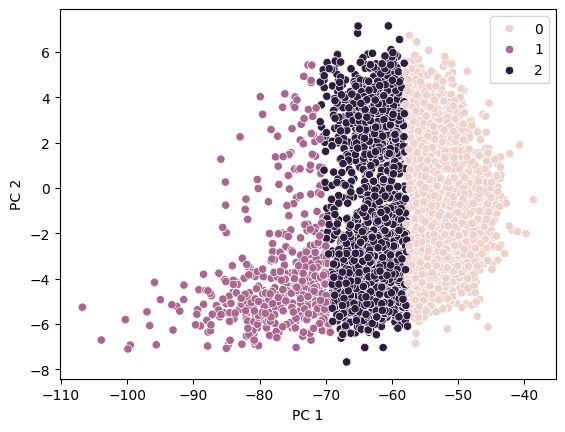

In [ ]:
sns.scatterplot(x=pca_reduced_impt[:,0], y =pca_reduced_impt[:,1],hue=predicted_labels)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [ ]:
np.linalg.norm(np.log(importances), axis=-1)

array([57.94101 , 64.73528 , 63.35975 , ..., 57.7258  , 68.086815,
       57.094303], dtype=float32)

In [ ]:
def pca_project(x, dim, weighted=True):
    xv = x
    if not weighted:
        xv = x / x.var(0)
    u, d, v = torch.pca_lowrank(xv,dim+10)
    return torch.matmul(x,v[:,:dim])

In [ ]:
norm_X = (big_X - big_X.mean(0)) / big_X.var(0)

<Axes: ylabel='Count'>

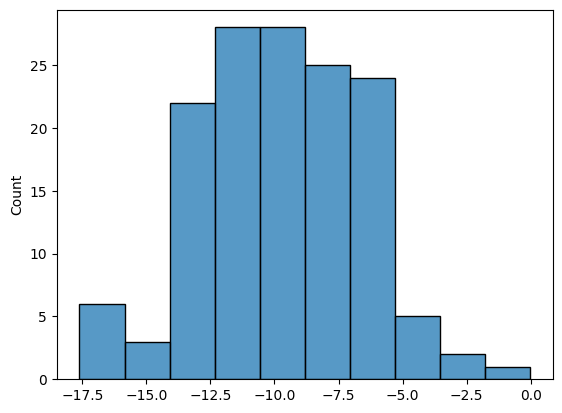

In [ ]:
sns.histplot(np.log(big_X.var(0)))

In [ ]:
(big_X < 1e-4).sum()

2538

In [ ]:
big_X.var(0)

array([[1.1755037e-03, 1.3670120e+00, 1.8443628e-03, ..., 3.3018538e-03,
        2.7158054e-02, 1.6401056e-04],
       [1.3448875e-03, 1.8861841e+00, 1.1630161e-03, ..., 1.4595613e-03,
        3.2474864e-03, 1.5804169e-03],
       [1.9562722e-04, 3.1992290e+00, 2.5941050e-03, ..., 2.1240897e-03,
        6.9699949e-04, 9.6067414e-04],
       ...,
       [5.1921536e-03, 4.4849089e-01, 1.1895746e-03, ..., 1.5509469e-02,
        2.5116937e-04, 3.7080487e-03],
       [1.5250899e-02, 3.8596103e-01, 5.8716144e-03, ..., 2.6388790e-02,
        2.8858386e-02, 5.1989192e-03],
       [2.5181696e-03, 2.5367576e-01, 8.4232073e-04, ..., 4.4700980e-02,
        6.8214955e-05, 7.3381402e-03]], dtype=float32)

In [ ]:
big_X+1e-8

array([[1.1755137e-03, 1.3670120e+00, 1.8443728e-03, ..., 3.3018638e-03,
        2.7158063e-02, 1.6402056e-04],
       [1.3448976e-03, 1.8861841e+00, 1.1630261e-03, ..., 1.4595713e-03,
        3.2474964e-03, 1.5804269e-03],
       [1.9563721e-04, 3.1992290e+00, 2.5941150e-03, ..., 2.1240998e-03,
        6.9700950e-04, 9.6068415e-04],
       ...,
       [5.1921634e-03, 4.4849089e-01, 1.1895846e-03, ..., 1.5509480e-02,
        2.5117939e-04, 3.7080587e-03],
       [1.5250909e-02, 3.8596103e-01, 5.8716242e-03, ..., 2.6388800e-02,
        2.8858395e-02, 5.1989290e-03],
       [2.5181796e-03, 2.5367576e-01, 8.4233074e-04, ..., 4.4700991e-02,
        6.8224952e-05, 7.3381499e-03]], dtype=float32)

In [ ]:
data_ts = np.log(big_X+1e-6)

In [ ]:
data_ts = norm_X

<Axes: ylabel='Count'>

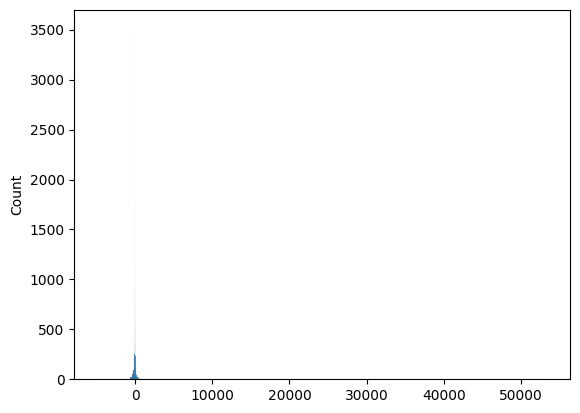

In [ ]:
sns.histplot(data_ts.flatten())